In [1]:
import pandas as pd
import numpy as np 

table_path = "/mnt/guido-data/mass/table.csv"
data_folder = "/mnt/guido-data/mass/raw/"
out_folder = "/mnt/guido-data/mass/emanuele/"


table = pd.read_csv(table_path, index_col = 0)
table.head()

KeyboardInterrupt: 

In [21]:
# iter over the rows of the table
from tqdm.autonotebook import tqdm
from scipy.signal import spectrogram
from physioex.preprocess.utils.signal import OnlineVariance
import os 

os.makedirs(out_folder, exist_ok=True)

ov = OnlineVariance( shape = (3, 5, 129) )

input_shape = [0, 3, 3000]
for i, row in tqdm(table.iterrows(), total=table.shape[0]):
    input_shape[0] = row["num_windows"]
    data_path = row["raw"]

    X = np.memmap(data_path, dtype="float32", mode="r", shape=tuple(input_shape))
    
    X = X.reshape( input_shape[0], 3, 5, 600 )
    
    _, _, Sxx = spectrogram(
        X.astype(np.double),
        fs=100,
        window="hamming",
        nperseg=200,
        noverlap=100,
        nfft=256,
    )

    # log_10 scale the spectrogram safely (using epsilon)
    Sxx = 20 * np.log10(np.abs(Sxx) + np.finfo(float).eps)

    Sxx = np.transpose(Sxx, (0, 1, 2, 4, 3))

    Sxx = Sxx.astype(np.float32)
    
    out_path = f"{out_folder}{i}.npy"
    
    # save the spectrogram on a new memmap file
    p_signal_memmap = np.memmap(
       out_path, dtype=np.float32, mode="w+", shape=Sxx.shape
    )
    
    p_signal_memmap[:] = Sxx[:]
    p_signal_memmap.flush()
    del p_signal_memmap
    
    Sxx = np.transpose(Sxx, (0, 2, 1, 3, 4))
    Sxx = Sxx.reshape( -1, 3, 5, 129 )
    
    ov.add(Sxx)

100%|██████████| 200/200 [06:13<00:00,  1.87s/it]


In [31]:
mean, std = ov.compute()

mean = np.repeat( mean.reshape(1, 3, 5, 129), 5, axis = 0)
mean = np.transpose(mean, (1, 0, 2, 3) )
mean.shape

std = np.repeat( std.reshape(1, 3, 5, 129), 5, axis = 0)
std = np.transpose(std, (1, 0, 2, 3) )

print(mean.shape, std.shape)

np.savez(f"{out_folder}scaling.npz", mean = mean, std = std)

(3, 5, 5, 129) (3, 5, 5, 129)


In [35]:
from physioex.data import PhysioExDataset

dataset = PhysioExDataset( 
        datasets = ["mass"],
        data_folder = "/mnt/guido-data/",
        preprocessing = "emanuele",
        selected_channels = ["EEG", "EOG", "EMG"],
        sequence_length = 1,
        indexed_channels = ["EEG", "EOG", "EMG"],
    )

signal, label = dataset[0]
print(signal.shape, label.shape)

signal = np.transpose(signal, (0, 2, 1, 3, 4)).reshape( -1, 3, 5, 129)
signal.shape

torch.Size([1, 3, 5, 5, 129]) torch.Size([1])


torch.Size([5, 3, 5, 129])

In [4]:
from typing import List, Callable
from physioex.data import PhysioExDataset

class EmanueleDataset( PhysioExDataset ):
    def __init__(
        self,
        datasets: List[str],
        data_folder: str,
        preprocessing: str = "raw",
        selected_channels: List[int] = ["EEG"],
        sequence_length: int = 21,
        target_transform: Callable = None,
        hpc: bool = False,
        indexed_channels: List[int] = ["EEG", "EOG", "EMG", "ECG"],
        task: str = "sleep",
    ):
        super().__init__(
            datasets = datasets,
            data_folder = data_folder,
            preprocessing = preprocessing,
            selected_channels = selected_channels,
            sequence_length = sequence_length,
            target_transform = target_transform,
            hpc = hpc,
            indexed_channels = indexed_channels,
            task = task,
        )

        self.emanuele_data = PhysioExDataset(
            datasets = datasets,
            data_folder = data_folder,
            preprocessing = "emanuele",
            selected_channels = selected_channels,
            sequence_length = sequence_length,
            target_transform = target_transform,
            hpc = hpc,
            indexed_channels = indexed_channels,
            task = task,
        )
        return

    def __getitem__(self, idx):
        X, _ = super().__getitem__(idx)
        X = X.reshape( self.L, len(self.channels_index), 5, 600)
        y, _ = self.emanuele_data.__getitem__(idx)        
        
        X = X.permute(0, 2, 1, 3)
        y = y.permute(0, 2, 1, 3, 4)
        
        X = X.reshape( self.L*5, len(self.channels_index), 600)
        y = y.reshape( self.L*5, len(self.channels_index), 5, 129)
        
        return X, y


emanuele_data = EmanueleDataset(
    datasets = ["mass"],
    data_folder = "/mnt/guido-data/",
    preprocessing = "raw",
    selected_channels = ["EEG", "EOG", "EMG"],
    sequence_length = 1,
    indexed_channels = ["EEG", "EOG", "EMG"],
)

print( emanuele_data )

from physioex.data.datamodule import PhysioExDataModule

datamodule = PhysioExDataModule(
    datasets = emanuele_data,
    batch_size = 32,
    )

from physioex.train.networks import config as network_config
from physioex.train.bin.parser import deep_update
import importlib

default_config = network_config["default"].copy()
config = network_config[ "samplereconstructor" ]

deep_update(default_config, config)
config = default_config

config["model_kwargs"]["in_channels"] = 
config["model_kwargs"]["sequence_length"] = 

module, class_name = config["model"].split(":")
config["model"] = getattr(importlib.import_module(module), class_name)

#model = config["model"](module_config = config["model_kwargs"])
from physioex.train.utils.train import train

train(
    datasets = datamodule,
    model_class = config["model"],
    model_config = config["model_kwargs"],
    model = None,
    monitor = "val_loss",
)


#print(signal.shape, label.shape)


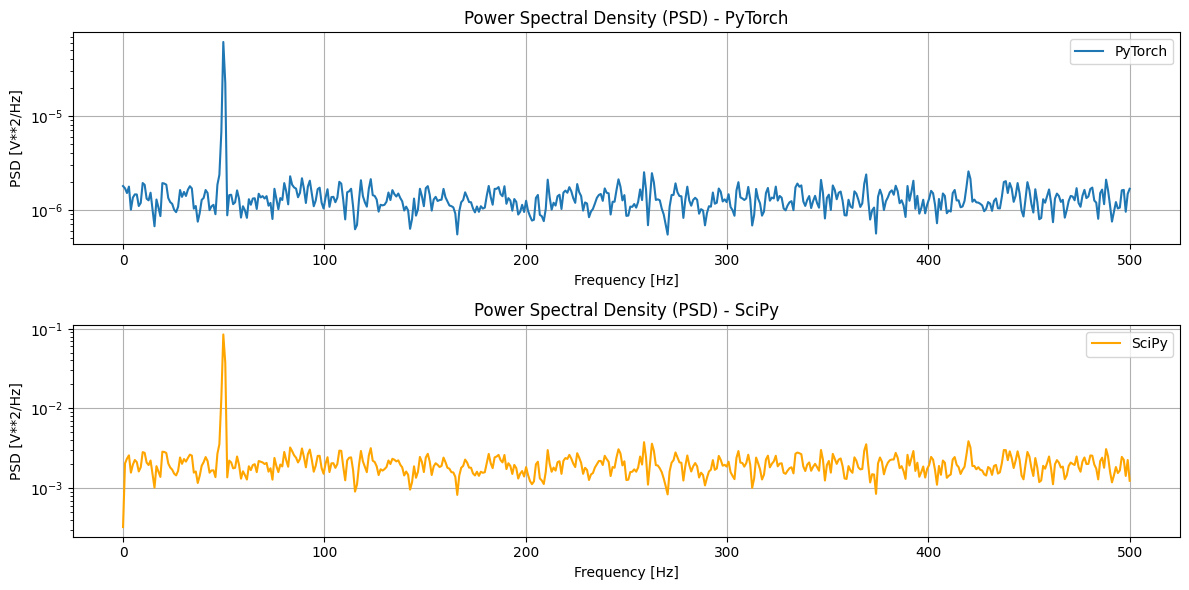

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def welch_psd(x, fs=1.0, nperseg=256, noverlap=None, nfft=None):
    if noverlap is None:
        noverlap = nperseg // 2
    if nfft is None:
        nfft = nperseg

    # Window function
    window = torch.hamming_window(nperseg, periodic=False)

    # Calculate the number of segments
    step = nperseg - noverlap
    shape = (x.size(0) - noverlap) // step, nperseg
    strides = x.stride(0) * step, x.stride(0)
    segments = torch.as_strided(x, size=shape, stride=strides)

    # Apply window to each segment
    segments = segments * window

    # Compute FFT and power spectral density
    fft_segments = torch.fft.rfft(segments, n=nfft)
    psd = (fft_segments.abs() ** 2) / (fs * window.sum() ** 2)

    # Average over segments
    psd = psd.mean(dim=0)

    # Frequency axis
    freqs = torch.fft.rfftfreq(nfft, 1 / fs)

    return freqs, psd

# Esempio di utilizzo
fs = 1000  # Frequenza di campionamento
N = 10000  # Numero di campioni
t = torch.arange(N) / fs
x = 0.5 * torch.sin(2 * np.pi * 50 * t) + torch.randn(N)  # Segnale di esempio

freqs_torch, psd_torch = welch_psd(x, fs=fs, nperseg=1024, noverlap=512, nfft=1024)

# Calcolo della PSD con SciPy
x_np = x.numpy()
freqs_scipy, psd_scipy = welch(x_np, fs=fs, nperseg=1024, noverlap=512, nfft=1024)

# Plot dei risultati
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.semilogy(freqs_torch.numpy(), psd_torch.numpy(), label='PyTorch')
plt.title('Power Spectral Density (PSD) - PyTorch')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogy(freqs_scipy, psd_scipy, label='SciPy', color='orange')
plt.title('Power Spectral Density (PSD) - SciPy')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()